# DT and RF Scoring for diabetes dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams["figure.figsize"] = (7,4)
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
#pd.set_option('display.width', 1000)
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv("diabetes.csv")

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Cleaning Outliers

In [4]:
df=df[df.SkinThickness<70]
df=df[df.Glucose>0]
df=df[df.BloodPressure>35]
df=df[df.BMI>0]

# outlierlardan hızlı pratik bir şekilde temizliyoruz.
#daha önce bu datayı uzunca incelediğimiz için gerekli cleaningi yapıyoruz.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               720 non-null    int64  
 1   Glucose                   720 non-null    int64  
 2   BloodPressure             720 non-null    int64  
 3   SkinThickness             720 non-null    int64  
 4   Insulin                   720 non-null    int64  
 5   BMI                       720 non-null    float64
 6   DiabetesPedigreeFunction  720 non-null    float64
 7   Age                       720 non-null    int64  
 8   Outcome                   720 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 56.2 KB


In [6]:
df.Outcome.value_counts()
#imbalanced olabilir..

0    473
1    247
Name: Outcome, dtype: int64

## Train | Test Split and Scalling

In [7]:
X = df.drop("Outcome",axis=1)
y = df["Outcome"]

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)

## Modelling and Model Performance

### Decision Tree

In [9]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score,f1_score

def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

# predict işlemi test datasını train datasındaki unique kategorik verilere göre transforma tabi tutarak numeric verilere 
# dönüştürüyor.

# pipeline içerisinde make_column_transform olduğundan df yapısı train datasında olduğu gibi değiştiriliyor ve predict edilmek 
# üzere ilgili modele gönderiliyor.

In [10]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(class_weight = "balanced", random_state=101)
dt_model.fit(X_train, y_train)
eval_metric(dt_model, X_train, y_train, X_test, y_test)

# datamız dengesiz olduğundan ve hedef labelımın skoru kötü olduğundan direk class_weight = "balanced" kullandım. Dengesiz
# data setlerinde class_weight'i gridsearche vermeye gerek yok.

Test_Set
[[75 20]
 [23 26]]
              precision    recall  f1-score   support

           0       0.77      0.79      0.78        95
           1       0.57      0.53      0.55        49

    accuracy                           0.70       144
   macro avg       0.67      0.66      0.66       144
weighted avg       0.70      0.70      0.70       144


Train_Set
[[378   0]
 [  0 198]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       378
           1       1.00      1.00      1.00       198

    accuracy                           1.00       576
   macro avg       1.00      1.00      1.00       576
weighted avg       1.00      1.00      1.00       576



In [11]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV

In [12]:
from sklearn.model_selection import StratifiedKFold

model = DecisionTreeClassifier(class_weight = "balanced", random_state=101)


cv = StratifiedKFold(n_splits=10)
scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision', 'recall', 'f1'],
                        cv = cv, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))

df_scores.mean()[2:]

# overfitingi teyit ediyorum.

test_accuracy      0.711766
train_accuracy     1.000000
test_precision     0.589251
train_precision    1.000000
test_recall        0.551316
train_recall       1.000000
test_f1            0.565202
train_f1           1.000000
dtype: float64

In [13]:
param_grid = {"splitter":["best", "random"],
              "max_features":[None, 3, 5, 7],
              "max_depth": [None, 2, 3],
              "min_samples_leaf": [2, 3, 5],
              "min_samples_split": [2, 3,4,5]}

In [14]:
model = DecisionTreeClassifier(class_weight="balanced", random_state=101)

cv = StratifiedKFold(n_splits=10)
dt_grid_model = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='recall',
                            cv = cv,
                            n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


In [15]:
dt_grid_model.best_params_

{'max_depth': 2,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'splitter': 'random'}

In [16]:
dt_grid_model.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=2, min_samples_leaf=2,
                       random_state=101, splitter='random')

In [17]:
eval_metric(dt_grid_model, X_train, y_train, X_test, y_test)

# overfiting yok görünüyor ama kesin teyidimizi CV'da yapacağız.

# Hedef classımız Test datasındaki 1 scorlarını  CV'dan alacağımız validation setlerinin ortalama değeri ile karşılaştırıp 
# skorumuzu teyit edeceğiz.

Test_Set
[[33 62]
 [ 5 44]]
              precision    recall  f1-score   support

           0       0.87      0.35      0.50        95
           1       0.42      0.90      0.57        49

    accuracy                           0.53       144
   macro avg       0.64      0.62      0.53       144
weighted avg       0.71      0.53      0.52       144


Train_Set
[[133 245]
 [  8 190]]
              precision    recall  f1-score   support

           0       0.94      0.35      0.51       378
           1       0.44      0.96      0.60       198

    accuracy                           0.56       576
   macro avg       0.69      0.66      0.56       576
weighted avg       0.77      0.56      0.54       576



In [18]:
model = DecisionTreeClassifier(class_weight='balanced', max_depth=2, min_samples_leaf=2,
                       random_state=101, splitter='random')

cv = StratifiedKFold(n_splits=10)
scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision', 'recall', 'f1'],
                        cv = cv, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))

df_scores.mean()[2:]

# Overfiting yok. Test datasındaki 1 classının skorları ile validation setinin skorları tutarlı.

test_accuracy      0.559074
train_accuracy     0.563274
test_precision     0.437143
train_precision    0.438265
test_recall        0.959474
train_recall       0.959595
test_f1            0.600060
train_f1           0.601704
dtype: float64

In [20]:
#pip install scikit-plot

In [21]:
#import sklearn
#print(sklearn.__version__)

In [19]:
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, plot_roc_curve, roc_auc_score, roc_curve,\
                            average_precision_score

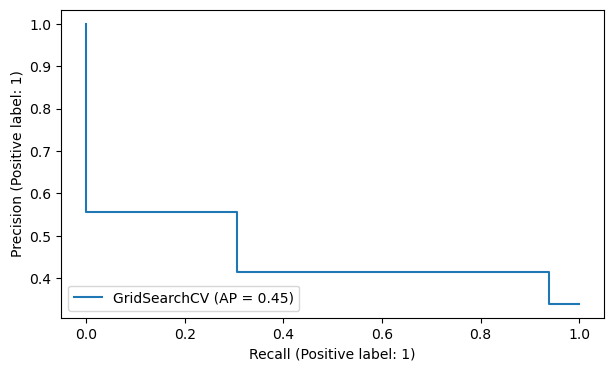

In [20]:
plot_precision_recall_curve(dt_grid_model, X_test, y_test);

#datam imbalanced olduğu için precision_recall a baktık.
# modelin genel performansı çok düşük.

### Random Forest

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [22]:
rf_model = RandomForestClassifier(class_weight = "balanced", random_state=101)
rf_model.fit(X_train, y_train)

# datamız dengesiz olduğundan ve hedef labelımın skoru kötü olduğundan direk class_weight = "balanced" kullandım. Dengesiz
# data setlerinde class_weight'i gridsearche vermeye gerek yok.

RandomForestClassifier(class_weight='balanced', random_state=101)

In [23]:
eval_metric(rf_model, X_train, y_train, X_test, y_test)

# overfiting var görünüyor.

Test_Set
[[83 12]
 [24 25]]
              precision    recall  f1-score   support

           0       0.78      0.87      0.82        95
           1       0.68      0.51      0.58        49

    accuracy                           0.75       144
   macro avg       0.73      0.69      0.70       144
weighted avg       0.74      0.75      0.74       144


Train_Set
[[378   0]
 [  0 198]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       378
           1       1.00      1.00      1.00       198

    accuracy                           1.00       576
   macro avg       1.00      1.00      1.00       576
weighted avg       1.00      1.00      1.00       576



In [24]:
model = RandomForestClassifier(class_weight = "balanced", random_state=101)

cv = StratifiedKFold(n_splits=10)
scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = cv,
                       return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))

df_scores.mean()[2:]

# overfiting olduğunu teyit ettim.

test_accuracy      0.763944
train_accuracy     1.000000
test_precision     0.702761
train_precision    1.000000
test_recall        0.570000
train_recall       1.000000
test_f1            0.616765
train_f1           1.000000
dtype: float64

### GridSearch

In [25]:
param_grid = {'n_estimators':[64, 128, 200],
             'max_features':[2, 4, 'sqrt'],
             'max_depth':[2, 3, 4],
             'min_samples_split':[2, 3,4],
             'min_samples_leaf': [2,3,4],
             'max_samples':[0.8, 1]} # add 1

In [26]:
model = RandomForestClassifier(class_weight={0:1, 1:4},random_state=101)
rf_grid_model = GridSearchCV(model, param_grid, scoring = "recall", n_jobs = -1, verbose=2).fit(X_train, y_train)

# class_weight="balanced" yetersiz geldiğinden 1'e 4 oranında ağırlıklandırıldı.

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


In [27]:
rf_grid_model.best_params_

{'max_depth': 2,
 'max_features': 2,
 'max_samples': 0.8,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 64}

In [28]:
rf_grid_model.best_estimator_

RandomForestClassifier(class_weight={0: 1, 1: 4}, max_depth=2, max_features=2,
                       max_samples=0.8, min_samples_leaf=2, n_estimators=64,
                       random_state=101)

In [29]:
rf_grid_model.best_score_

0.9597435897435898

In [30]:
eval_metric(rf_grid_model, X_train, y_train, X_test, y_test)

# overfiting giderilmiş görünüyor ama kesin teyidimizi CV'da yapacağız.

# Hedef classımız Test datasındaki 1 scorlarını  CV'dan alacağımız validation setlerinin ortalama değeri ile karşılaştırıp 
# skorumuzu teyit edeceğiz.

Test_Set
[[45 50]
 [ 5 44]]
              precision    recall  f1-score   support

           0       0.90      0.47      0.62        95
           1       0.47      0.90      0.62        49

    accuracy                           0.62       144
   macro avg       0.68      0.69      0.62       144
weighted avg       0.75      0.62      0.62       144


Train_Set
[[154 224]
 [  3 195]]
              precision    recall  f1-score   support

           0       0.98      0.41      0.58       378
           1       0.47      0.98      0.63       198

    accuracy                           0.61       576
   macro avg       0.72      0.70      0.60       576
weighted avg       0.80      0.61      0.60       576



In [31]:
model = RandomForestClassifier(class_weight={0: 1, 1: 4}, max_depth=2, max_features=2,
                       max_samples=0.8, min_samples_leaf=2, n_estimators=64,
                       random_state=101)

cv = StratifiedKFold(n_splits=10)

scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision', 'recall', 'f1'],
                        cv = cv, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))

df_scores.mean()[2:]

# Overfiting olmadığını teyit ettim. Test datasındaki 1 classının skorları ile validation setinin skorları tutarlı.

test_accuracy      0.604144
train_accuracy     0.614193
test_precision     0.464524
train_precision    0.470670
test_recall        0.965000
train_recall       0.979242
test_f1            0.626629
train_f1           0.635736
dtype: float64

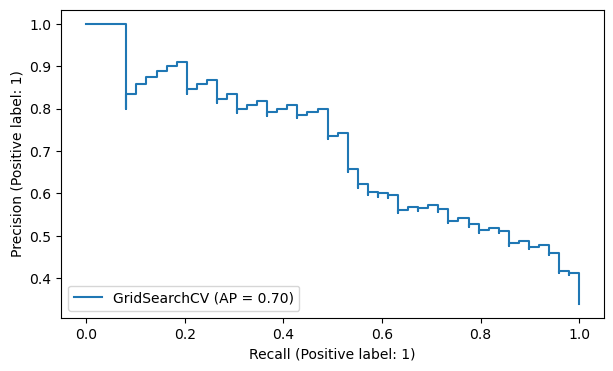

In [32]:
plot_precision_recall_curve(rf_grid_model, X_test, y_test);

# RF modelin genel performancı DT'den çok daha iyi

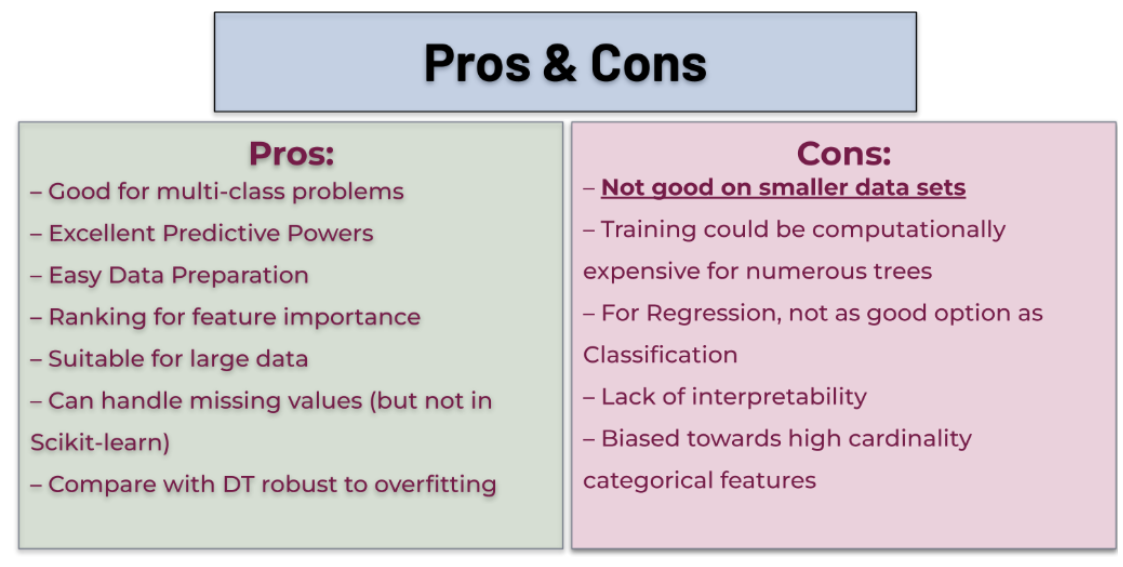